In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'
from datetime import datetime 
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data['Time'] = data['Time'].apply(lambda x : datetime.fromtimestamp(x))

먼저 rating 3 이하인 아이템을 제거한다. 

In [3]:
data = data[data['Rating'] > 3]
data.describe()

,UserId,ItemId,Rating
count,575281.000000,575281.000000,575281.000000
mean,3038.114852,1817.587070,4.393390
std,1733.654125,1083.844338,0.488503
min,1.000000,1.000000,4.000000
25%,1533.000000,1022.000000,4.000000
50%,3080.000000,1648.000000,4.000000
75%,4505.000000,2750.000000,5.000000
max,6040.000000,3952.000000,5.000000


그리고 ItemId의 분포를 보고 적게 추천된 영화는 제외한다. 

In [4]:
data.groupby('ItemId').size().describe()

count    3533.000000
mean      162.830739
std       285.798512
min         1.000000
25%        13.000000
50%        49.000000
75%       183.000000
max      2853.000000
dtype: float64

13번 이하로 추천된 영화는 일단 지운다. 

In [5]:
#print()
#data[data]
maniac_item = data.groupby('ItemId').size().apply(lambda x : x <= 13)

result = data.groupby('ItemId').size()[maniac_item]
result = result.index.tolist()
#data = data[data['ItemId'][maniac_item]]

In [6]:
drop_list = []
for i in result : 
    temp = data[data['ItemId'] == i].index.tolist()
    if temp : 
        drop_list += temp
data.drop(drop_list)

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
36,1,1836,5,2001-01-01 07:02:52
...,...,...,...,...
1000119,6040,3671,4,2001-08-10 23:39:27
999923,6040,232,5,2001-08-10 23:39:58
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04


이제는 user와 item에 대해서 정리할 시간이다. 평가에 몇 번 참가하지 않았거나 너무 많이 평가에 참여햔 비정상적인 경우를 보려고 한다. 

In [7]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6038, 3533)

In [8]:
user_length = data.groupby('UserId').size()

In [9]:
print(user_length.describe())

count    6038.000000
mean       95.276747
std       105.005005
min         1.000000
25%        27.000000
50%        58.000000
75%       124.000000
max      1435.000000
dtype: float64


In [10]:
user_length.quantile(0.999)

816.8890000000019

In [11]:
heavy_user = user_length[user_length==2314]
print(len(heavy_user))

0


In [12]:
heavy_users = user_length.apply(lambda x : x > 1343)
heavy_users = user_length[heavy_users]
heavy_users_sort = sorted(heavy_users)
print(heavy_users_sort)

[1435]


1초에 한 유저가 몇 번 만큼 평가했는지 알아보려고 제일 많이 평가를 한 유저에 대해 조사를 해보았다. 

In [13]:
click_num = []
for user in heavy_users_sort :
    row = data[data['UserId'] == user]
    #print(row)
    # 일단은 1초에 몇번만큼 겹치게 클릭했는지 구해보려고 한다.
    count_time = row['Time'].unique()
    multi_click = row['Time'].apply(lambda x : x not in count_time)
    click_num.append(len(multi_click))

In [14]:
print(click_num)

[20]


이 사람은 20초에 해당하는 시간동안(합산 20초) 1초에 여러번 평가했다. 

근데 Time이 겹칠 수 밖에 없는게, 이 사이트는 정말 단순하게 rating을 한다. 
직접 Movielens에 가입해서 rating 하는 페이지까지 접근해서 하나 시험삼아 해보았다. 
페이지는 영화 포스터와 별 5개로 표현하는 rating으로 이루어진 패널들로 차 있는데, 원하는 영화 패널을 클릭해서 별이 그려진 부분에서 마우스를 움직이면 바로 별이 차오르는 방식을 택하고 있어서, 1분 안에서는 영화를 빠르게 평가할 수 있다. 하지만 데이터는 초 단위로 기록이 되어있다. 그래서 이상 유저들을 바로 걸러내야 할 필요가 있다. 1초 내에 3번->5번(생각보다 3번 이상 평가한 손빠른 사람들이 많았다.) 이상의 평가를 한 경우 이상 유저로 간주하여 데이터에서 완전히 제외할 생각이다. 

In [15]:

def check_multi_click_user(data) :
    #print(data)
    time_list = data.groupby('Time').size()
    #print(time_list)
    duplicated_click = time_list[lambda x : x > 5]
    
    #print(duplicated_click)
    return duplicated_click
def find_abnomal_user(data) :
    all_dup = []
    ls = data['UserId'].unique()
    ab_us = []
    for i in ls :
        result = []
        result = check_multi_click_user(data[data['UserId']==i])
        if len(result) != 0 :
            #print(i,result)
            ab_us.append(i)    
    return ab_us
ab_us_ls = find_abnomal_user(data)
#print(ab_us_ls)

In [16]:
print(len(ab_us_ls))

1827


In [17]:
for i in ab_us_ls : 
    temp = data[data['ItemId'] == i].index.tolist()
    data.drop(temp)
print(data.describe())

              UserId         ItemId         Rating
count  575281.000000  575281.000000  575281.000000
mean     3038.114852    1817.587070       4.393390
std      1733.654125    1083.844338       0.488503
min         1.000000       1.000000       4.000000
25%      1533.000000    1022.000000       4.000000
50%      3080.000000    1648.000000       4.000000
75%      4505.000000    2750.000000       5.000000
max      6040.000000    3952.000000       5.000000


In [18]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum()/length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]
print(length_percent_cumsum_999)

1      0.000166
2      0.000497
4      0.000662
5      0.001656
6      0.003644
         ...   
788    0.998178
792    0.998344
794    0.998509
800    0.998675
814    0.998841
Length: 480, dtype: float64


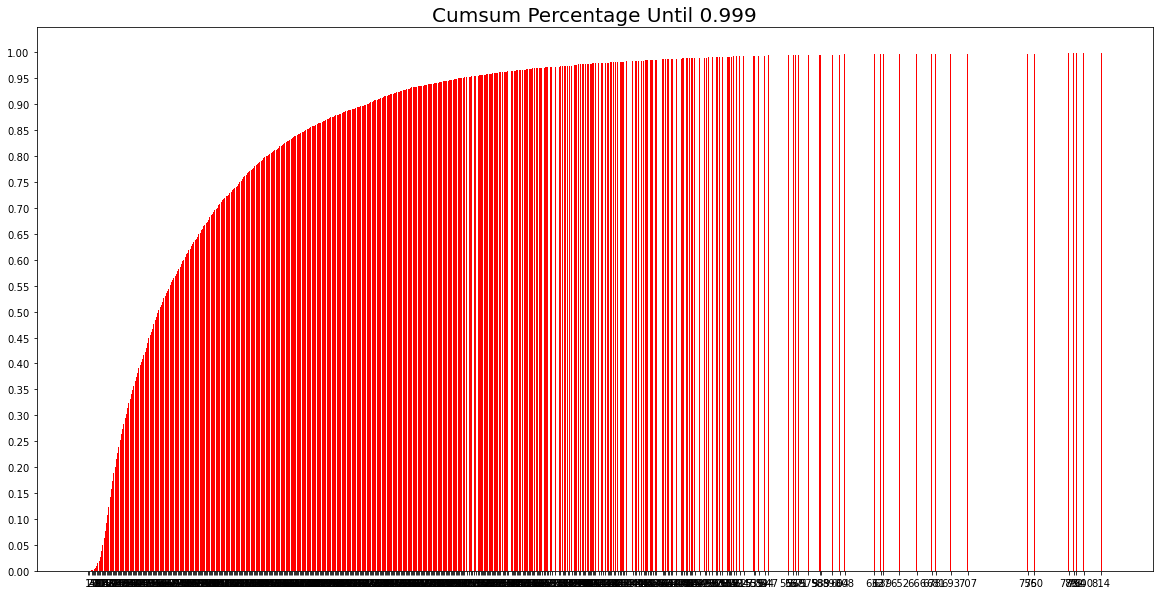

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [22]:
item_length = data.groupby('ItemId').size()
item_length.describe()

count    3533.000000
mean      162.830739
std       285.798512
min         1.000000
25%        13.000000
50%        49.000000
75%       183.000000
max      2853.000000
dtype: float64

In [23]:
user_length = data.groupby('UserId').size()
print(user_length.describe())

count    6038.000000
mean       95.276747
std       105.005005
min         1.000000
25%        27.000000
50%        58.000000
75%       124.000000
max      1435.000000
dtype: float64


그리고 25퍼센트 미만의 출현 횟수를 가진 user와 item을 지운다. user는 27번, item은 13번으로 기준을 잡겠다.

In [24]:
def clean_short_record(data : pd.DataFrame, shortest) :
    user_len = data.groupby('UserId').size()
    normal_user = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(normal_user)]
    return data
def clean_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = clean_short_record(data, shortest)
        data = clean_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

In [25]:
data = cleanse_recursive(data, shortest=27, least_click=33)

소비패턴은 1년을 주기로 변하기 때문에, 미니배치를 1년 단위로 자른다. 전체 기간이 4년인데 첫 2년을 학습데이터, 그 다음 1년을 validation, 그 다음 1년을 test로 본다. 

In [26]:
gap = (latest - oldest)//4
print(gap)

259 days 16:41:04.500000


In [27]:
def split_by_date(data: pd.DataFrame, n_days):
    final_time = data['Time'].max()
    #print(final_time) 
    #last_time = data['Time'].max()
    train = data['Time'].apply(lambda x : x < final_time - n_days)
    test = data['Time'].apply(lambda x : x >= final_time - n_days)

    before_date = data[train]
    after_date = data[test]
    #after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [28]:
tr, test = split_by_date(data, n_days = gap)
tr, val = split_by_date(tr, n_days = gap)

In [29]:
origin_tr = tr
origin_test = test
origin_val = val

In [30]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [31]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 511534
	 Users: 4537
	 Items: 2000
	 First Time : 2000-04-26 08:05:32
	 Last Time : 2001-09-27 12:31:39

* valid Set Stats Info
	 Events: 11202
	 Users: 529
	 Items: 1807
	 First Time : 2001-09-28 01:15:19
	 Last Time : 2002-06-14 07:56:48

* test Set Stats Info
	 Events: 6934
	 Users: 371
	 Items: 1607
	 First Time : 2002-06-14 13:09:46
	 Last Time : 2003-03-01 02:49:50



In [32]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}
def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [33]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 모델 준비하기
## 파이프라인 준비하기

In [126]:
#tr =  origin_tr
val =  origin_val
test = origin_test

In [ ]:
먼저 세션 아이디를 만든다. 시간별로 정렬한 후, 한 유저당 가장 먼저 평가한 시간과 가장 늦게 평가한 시간의 차를 구한 후, 이를 기준으로 세션을 나눈다. 

In [127]:
tr_user_list = tr['UserId'].unique()
gaps = []
for i in tr_user_list :
    temp = data[data['UserId'] == i]
    old = min(temp['Time'])
    new = max(temp['Time'])
    gap = new - old
    gap = gap.total_seconds()
    gaps.append(gap)
gaps = pd.DataFrame(gaps)
pd.options.display.float_format = "{:.4f}".format
print(gaps.describe())

                  0
count     4537.0000
mean  10005785.4884
std   20610173.5374
min        139.0000
25%       2026.0000
50%      12658.0000
75%    5251929.0000
max   89247792.0000


In [128]:
gaps.describe().iloc[4]

0   2026.0000
Name: 25%, dtype: float64

그렇다면 각 값이 몇 분을 의미하는지 한번 계산해 보자.

In [129]:
print(139//60,'분')
print(2026//60,"분")
print(12658//60, "분")
print(5251929//60//60//60, "일")
print(89247792//60//60//60, "일")

2 분
33 분
210 분
24 일
413 일


짧게 활동한 유저는 33분, 가장 길게 활동한 유저는 413일을 활동했다. 제일 짧게 활동한 유저를 기준으로 세션을 나누겠다. 
세션 번호를 부여할 함수를 만들려고 한다. 
단순히 time을 33분 단위로 묶어 세션번호를 부여할 것이다. 왜냐하면 세션은 '익명의 한 유저'를 기반으로 하고, 그 유저가 여러 세션을 가질 수 있기 때문에 UserId와 무관하게 시간 기준으로 33분 단위로 세션을 나눈다. 

In [130]:
time_sort = list(tr['Time'])
time_sort.sort()
oldest = time_sort[0]
latest = time_sort[-1]
count = 0
session_index = []
next_start = oldest
first_index = 0
last_index = len(time_sort)
while oldest <= latest :
    next_time = oldest + dt.timedelta(seconds = 60*33) 
    flag = False
    for i in range(first_index, len(time_sort)) :
        if oldest <= time_sort[i] <= next_time :
            session_index.append(count)
            flag = True
        else : 
            # 다음 서치할 범위 저장 
            first_index = i
            if flag :
                count += 1
            break
    
    oldest = next_time
print(pd.DataFrame(session_index).describe())    

                0
count 511534.0000
mean    4210.5477
std     2254.7629
min        0.0000
25%     2486.0000
50%     4639.0000
75%     5755.0000
max    10861.0000


In [131]:
tr.sort_values(['Time'], inplace=True)
tr['SessionId'] = session_index

In [59]:
print(tr.head(20))
print(tr.tail(20))

         UserId  ItemId  Rating                Time  item_idx  SessionId
1000138    6040     858       4 2000-04-26 08:05:32       730          0
999873     6040     593       5 2000-04-26 08:05:54        54          0
1000153    6040    2384       4 2000-04-26 08:05:54      1458          0
1000007    6040    1961       4 2000-04-26 08:06:17        13          0
1000192    6040    2019       5 2000-04-26 08:06:17       646          0
999920     6040     213       5 2000-04-26 08:07:36      1657          0
999967     6040    3111       5 2000-04-26 08:07:36      1592          0
999980     6040    3505       4 2000-04-26 08:07:36       796          0
999884     6040     912       5 2000-04-26 08:09:51       208          0
999888     6040     919       5 2000-04-26 08:09:51        10          0
1000186    6040     527       5 2000-04-26 08:10:19        35          0
999991     6040     318       4 2000-04-26 08:10:57        50          0
1000063    6040    1252       5 2000-04-26 08:10:57

위의 과정을 val과 test에도 반복해준다.

In [139]:
def create_session_index(tr) :
    tr_user_list = tr['UserId'].unique()
    gaps = []
    for i in tr_user_list :
        temp = data[data['UserId'] == i]
        old = min(temp['Time'])
        new = max(temp['Time'])
        gap = new - old
        gap = gap.total_seconds()
        gaps.append(gap)
    gaps.sort()
    #print(gaps)
    gaps = pd.DataFrame(gaps)
    pd.options.display.float_format = "{:.4f}".format
    
    min_gap = int(gaps.describe().iloc[3])//60*60
    # 너무 갭이 큰 경우는 train 데이터를 기준으로 갭을 삼아준다. 
    if min_gap > 33*60 :
        min_gap = 33*60
    #print(min_gap)
    gap = dt.timedelta(seconds = int(min_gap))
    #print(gap)
    time_sort = list(tr['Time'])
    time_sort.sort()
    oldest = time_sort[0]
    latest = time_sort[-1]
    count = 0
    session_index = []
    next_start = oldest
    first_index = 0
    last_index = len(time_sort)
    while oldest <= latest :
        next_time = oldest + gap
        flag = False
        for i in range(first_index, len(time_sort)) :
            if oldest <= time_sort[i] <= next_time :
                session_index.append(count)
                flag = True
            else : 
                # 다음 서치할 범위 저장 
                first_index = i
                if flag :
                    count += 1
                break

        oldest = next_time
    #print(pd.DataFrame(session_index).describe())
    return session_index
val.sort_values(['Time'], inplace=True)
#create_session_index(val)
val['SessionId'] = create_session_index(val)
test.sort_values(['Time'], inplace=True)
test['SessionId'] = create_session_index(test)

그리고 세션 길이가 1인 세션은 지워준다. 

In [143]:
def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data
tr = cleanse_short_session(tr, 2)
val = cleanse_short_session(val,2)
test = cleanse_short_session(test,2)
print(val.head(20))
print(val.tail(20))
print(test.head(20))
print(test.tail(20))


        UserId  ItemId  Rating                Time  item_idx  SessionId
720283    4312    3917       4 2001-09-28 05:54:37       760          3
720284    4312    3918       4 2001-09-28 05:55:07      1253          3
720712    4312    2034       4 2001-09-28 06:02:37      1116          3
720070    4312    1194       4 2001-09-28 06:03:04      1776          3
720049    4312    2114       4 2001-09-28 06:06:11      1280          3
720444    4312    3679       4 2001-09-28 06:06:31      1659          3
720617    4312    3398       4 2001-09-28 06:09:44       678          3
719859    4312     595       4 2001-09-28 06:25:12        36          4
720668    4312    1059       4 2001-09-28 06:29:07       474          4
720369    4312    2294       4 2001-09-28 06:32:43        40          4
720564    4312    1735       4 2001-09-28 06:34:24       252          4
720606    4312     175       4 2001-09-28 06:34:38       822          4
811037    4867    2492       4 2001-09-29 00:39:44      1965    

In [69]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [144]:
tr_dataset = SessionDataset(tr)
print(tr_dataset.df.head(10))
print(tr_dataset.df.tail(10))
print(tr_dataset.click_offsets)
print(tr_dataset.session_idx)

         UserId  ItemId  Rating                Time  item_idx  SessionId
1000138    6040     858       4 2000-04-26 08:05:32       730          0
999873     6040     593       5 2000-04-26 08:05:54        54          0
1000153    6040    2384       4 2000-04-26 08:05:54      1458          0
1000007    6040    1961       4 2000-04-26 08:06:17        13          0
1000192    6040    2019       5 2000-04-26 08:06:17       646          0
999920     6040     213       5 2000-04-26 08:07:36      1657          0
999967     6040    3111       5 2000-04-26 08:07:36      1592          0
999980     6040    3505       4 2000-04-26 08:07:36       796          0
999884     6040     912       5 2000-04-26 08:09:51       208          0
999888     6040     919       5 2000-04-26 08:09:51        10          0
        UserId  ItemId  Rating                Time  item_idx  SessionId
720127    4312    3178       4 2001-09-26 06:56:54       517      10851
719939    4312    3408       4 2001-09-26 07:06:29   

In [145]:
val_dataset = SessionDataset(val)
print(val_dataset.df.head(10))
print(val_dataset.df.tail(10))
print(val_dataset.click_offsets)
print(val_dataset.session_idx)

        UserId  ItemId  Rating                Time  item_idx  SessionId
720283    4312    3917       4 2001-09-28 05:54:37       760          3
720284    4312    3918       4 2001-09-28 05:55:07      1253          3
720712    4312    2034       4 2001-09-28 06:02:37      1116          3
720070    4312    1194       4 2001-09-28 06:03:04      1776          3
720049    4312    2114       4 2001-09-28 06:06:11      1280          3
720444    4312    3679       4 2001-09-28 06:06:31      1659          3
720617    4312    3398       4 2001-09-28 06:09:44       678          3
719859    4312     595       4 2001-09-28 06:25:12        36          4
720668    4312    1059       4 2001-09-28 06:29:07       474          4
720369    4312    2294       4 2001-09-28 06:32:43        40          4
        UserId  ItemId  Rating                Time  item_idx  SessionId
583109    3562    3791       5 2002-06-14 01:11:17      1627       2144
583586    3562    3512       4 2002-06-14 01:13:24      1069    

In [167]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                #print(inp,target)
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)
            #print(start, end, mask, last_session, finished)
    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        #print(first_iters)
        #print(len(first_iters))
        #print(last_session)
        #print(len(self.dataset.click_offsets))
        #print(len(self.dataset.session_idx))
        #print(self.dataset.click_offsets)
        #print(self.dataset.session_idx)
        #print(self.dataset.session_idx[first_iters])
        
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [158]:
iter_ex = iter(tr_data_loader)

In [165]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

[]
Model Input Item Idx are : [1592  225  290 1779]
Label Item Idx are :       [ 796 1664  889  965]
Previous Masked Input Idx are []


In [98]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [99]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [100]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [101]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [102]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(2048, 1, 2000)]         0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  307800    
_________________________________________________________________
dropout_1 (Dropout)          (2048, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (2048, 2000)              102000    
Total params: 409,800
Trainable params: 409,800
Non-trainable params: 0
_________________________________________________________________


In [121]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [168]:
train_model(model, args)

Train:   0%|          | 0/244 [00:00<?, ?it/s, accuracy=0.0229, train_loss=6.25]

	 - Recall@20 epoch 1: nan
	 - MRR@20    epoch 1: nan



Train:   0%|          | 0/244 [00:00<?, ?it/s, accuracy=0.0249, train_loss=6.21]

	 - Recall@20 epoch 2: nan
	 - MRR@20    epoch 2: nan



Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

	 - Recall@20 epoch 3: nan
	 - MRR@20    epoch 3: nan



# 결론
일단 왜 그런지 모르겠지만 모델이 제대로 돌아가지 않아서 루브릭 1번만 완료했다. 
허탈하다...ㅠㅠㅠㅠ모델은 제출 이후 다른 분들 코드 보고 왜 모델이 안 돌아가는지 알아봐야겠다.
그리고 별개로 모델이 좀 나이브하게 짜인것 같다...ㅠㅠㅠㅠㅠ
